# Introduction

The purpose of this notebook is twofold:

1. Test the `NMFE` class methods. 
2. Demonstrate `NMFE` capabilities.

Note: these tests are not exhaustive.


In [1]:
from importlib import reload
import numpy as np
import skimage
from skimage import io
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import glob
from sklearn.decomposition import NMF
from platform import python_version
import operator
from operator import truediv as divs
import scipy
from scipy.spatial.distance import cdist

print(f"sklearn version: {sklearn.__version__}")
print(f"numpy version: {np.__version__}")
print(f"skimage version: {skimage.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"\n--> Python version: {python_version()} <--")

sklearn version: 0.20.0
numpy version: 1.16.3
skimage version: 0.16.2
seaborn version: 0.9.0
matplotlib version: 3.1.1
scipy version: 1.3.2

--> Python version: 3.7.5 <--


# Load Test Data

Here are a few cell-painted assays to show how `NMFE` works. There is a readme in the the `images/` folder with a citation, and a description of the data.

In [2]:
def load_images(dir_path, ext):
    """ 
    A function to load images from a given directory.
    This function assumes grey-scale.
    
    ARGS:
        - dir_path (string): relative directory path.
        - ext (string): filename extension (indluding period)
            and wildcard. Example: `/*.tif`
        
    RETURNS:
        - list of np.arrays
    """
    img_files = glob.glob(dir_path + ext)
    return [io.imread(img_file, as_gray=True) for img_file in img_files]
        

img_list = load_images("images/BBBC022_v1_images_20585w1", "/*.tif")

# Import Tests

The module should behave reasonably under "normal" import procs. 

In [163]:
# import top-level module. Should NOT return or produce anything.
# `reload` will return the module. 
import NMFE
reload(NMFE)

help(NMFE)

Help on module NMFE:

NAME
    NMFE - Non-negative matrix factorization extension (NFME).

DESCRIPTION
    A collection of tools from other libraries designed to
    make working with non-negative matrix factorization a 
    little more friendly.
    
    AUTHOR: Cooper M. Stansbury

CLASSES
    builtins.object
        NMFE
    
    class NMFE(builtins.object)
     |  NMFE(input_matrix=None, norm=False, **kwargs)
     |  
     |  A class to make exploring non-negative matrix factorizations more
     |  efficient and fun. This class builds on various linear alegebra tools
     |  in numpy, scipy, and sklearn and is loosely inspired by some ideas
     |  in nimfa. Non-negative matrix factorization takes an input matrix (I)
     |  and estimates two matrices (W and H) whose product is approximately
     |  I. This approximation (E) will vary based on different parameters
     |  to the factorization. NMFE is designed to help explore these changes
     |  empirically in order to "sanity" c

In [4]:
# remove `NMFE` from workspace.
del(NMFE)

# import specific module
from NMFE import NMFE

# show methods and attributes of uninitiated class
print(dir(NMFE))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_inputs', '_compute_residuals', '_fit', '_scale', 'compute_dist', 'compute_explained_variance', 'compute_hausdorff', 'compute_rss', 'get_residual_norm', 'plot', 'plot_IE', 'plot_all', 'refit', 'score_features', 'to_square']


# Initialization Tests

`NMFE` should only be possible to initialize will data and with `n_components` specified. This is a departure from the way that `sklearn` allows a user to interact with the object. My decision makes this class less flexible, but more straightforward to use. 

In [5]:
# `__init__` is handled primarily by the `_check_inputs` function:
help(NMFE._check_inputs)

Help on function _check_inputs in module NMFE:

_check_inputs(self, mat)
    A dunder method to gracefully handle NMFE specific inputs.
    All other inputs are expected to be handled by the target.
    The primary reason for this class is to ensure `__init__()`
    is called appropriately. Raises `ValueError` with specific 
    messages if `__init__()` is called without a matrix or 
    `n_components` defined.
    
    ARGS:
        - mat (np.array): arg present to check
            input before attribute is set.
        
    RAISES:
        - `ValueError` with messages depending on the
            severity of the infraction.



In [6]:
# failed initialization I 
# expect failure because initialization improperly called
nmfe = NMFE()

ValueError: NMFE instantiated without an `input_matrix` specified. Try: `NMFE(input_matrix=<np.array>)`

In [7]:
# failed initialization II
# expect failure because initialization improperly called
# randomly sample an image from loaded images
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix])

ValueError: NMFE instantiated without `n_components` specified. Try: `NMFE(n_components=<int>)`

In [8]:
# successful intialization with a random
# image from the test data
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

In [9]:
# here we can see the available attributes and methods of the class
print(dir(nmfe))

['E', 'E_ns', 'E_rank', 'H', 'I', 'I_ns', 'I_rank', 'R', 'W', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__version__', '__weakref__', '_check_inputs', '_compute_residuals', '_fit', '_n_components', '_scale', 'compute_dist', 'compute_explained_variance', 'compute_hausdorff', 'compute_rss', 'get_residual_norm', 'init_kwargs', 'issquare', 'normalized', 'plot', 'plot_IE', 'plot_all', 'refit', 'rss', 'score_features', 'to_square']


In [10]:
# __str__ method truncates the input
print(nmfe)

NMFE(input_matrix=<class 'numpy.ndarray'>, norm=False, n_components=2)


In [11]:
# note - the deafault is to NOT print entire `np.arrays` - even for `__repr__`.
# here we use the global variable `PRINT_OPTIONS` to set a reasonable default.
repr(nmfe)

'NMFE(input_matrix=[[144. 130. 135. ... 135. 133. 137.]\n [131. 124. 141. ... 143. 141. 133.]\n [136. 140. 133. ... 141. 142. 141.]\n ...\n [139. 149. 144. ... 160. 151. 155.]\n [152. 151. 147. ... 155. 156. 151.]\n [151. 153. 152. ... 149. 151. 154.]]>, norm=False, n_components=2)'

# Initialized Object and Attributes

The initialized object has five primary matrices:

1. `I` the input matrix
2. `W` and `H`, the matrices whose product approximates `I`
3. `E` the product of `W` and `H` (estimation)
4. `R` the difference of `I` and `E` (residuals).

In [12]:
# first, we take a look at the "loaded" objects
# we expect five primary matrices upon initialization of the matrix
def print_shapes(nmfe):
    """ a quick print function """
    for attr in ['E', 'H', 'I', 'R', 'W']:
        val = getattr(nmfe, attr)
        if not val is None:
            print(f"nmfe.{attr} is {type(val)} with shape {val.shape}")
            
print_shapes(nmfe)

nmfe.E is <class 'numpy.ndarray'> with shape (520, 696)
nmfe.H is <class 'numpy.ndarray'> with shape (2, 696)
nmfe.I is <class 'numpy.ndarray'> with shape (520, 696)
nmfe.R is <class 'numpy.ndarray'> with shape (520, 696)
nmfe.W is <class 'numpy.ndarray'> with shape (520, 2)


In [13]:
# here an example of the input <np.array>
print(f"type: {type(nmfe.I)}")
nmfe.I

type: <class 'numpy.ndarray'>


array([[144., 130., 135., ..., 135., 133., 137.],
       [131., 124., 141., ..., 143., 141., 133.],
       [136., 140., 133., ..., 141., 142., 141.],
       ...,
       [139., 149., 144., ..., 160., 151., 155.],
       [152., 151., 147., ..., 155., 156., 151.],
       [151., 153., 152., ..., 149., 151., 154.]])

In [14]:
# here are a few other attributes of the object
def print_attrs(nmfe, spacer=""):
    """ a quick function to get attributes """
    print(f"{spacer}version: {nmfe.__version__}")
    print(f"{spacer}initialization keyword arguements: {nmfe.init_kwargs}")
    print(f"{spacer}inner product rank (n_components): {nmfe._n_components}")
    print(f"{spacer}input is square?: {nmfe.issquare}")
    print(f"{spacer}input was normalized?: {nmfe.normalized}")
    print(f"{spacer}input rank: {nmfe.I_rank}")
    print(f"{spacer}input null-space shape: {nmfe.I_ns.shape}")
    print(f"{spacer}estimation rank: {nmfe.E_rank}")
    print(f"{spacer}input null-space shape: {nmfe.E_ns.shape}")
    print(f"{spacer}residual shape: {nmfe.R.shape}")
    print(f"{spacer}default rss value: {nmfe.rss}")
    
print_attrs(nmfe)

version: 0.0.1
initialization keyword arguements: {'n_components': 2}
inner product rank (n_components): 2
input is square?: False
input was normalized?: False
input rank: 520
input null-space shape: (696, 176)
estimation rank: 520
input null-space shape: (696, 176)
residual shape: (520, 696)
default rss value: None


# Methods

In [15]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], 
            n_components=10)

In [16]:
# below we list the methods (excluding dunders)
methods = [i for i in dir(nmfe) if callable(getattr(nmfe, i)) \
               and not i.startswith("_")]
methods

['compute_dist',
 'compute_explained_variance',
 'compute_hausdorff',
 'compute_rss',
 'get_residual_norm',
 'plot',
 'plot_IE',
 'plot_all',
 'refit',
 'score_features',
 'to_square']

In [17]:
# first thing we'll try is refitting with different 
# parameters
help(nmfe.refit)

Help on method refit in module NMFE:

refit(norm=False, **kwargs) method of NMFE.NMFE instance
    A method to recompute the factorization ON THE SAME INPUT.
    
    ARGS:
        - norm (bool): if True, scale the `mat` arg to range [0,1]
            
        - kwargs (dict): parameters to pass to `NMF.fit_transform()`
            
    RETURNS:
        - re-initializes the class and key attributes.



In [18]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

print(f"Before `refit()`")
print_attrs(nmfe, spacer="\t")

nmfe.refit(norm=True, n_components=3, 
           init='random', solver='mu')
print(f"\nAfter `refit()`")
print_attrs(nmfe, spacer="\t")

Before `refit()`
	version: 0.0.1
	initialization keyword arguements: {'n_components': 2}
	inner product rank (n_components): 2
	input is square?: False
	input was normalized?: False
	input rank: 520
	input null-space shape: (696, 176)
	estimation rank: 520
	input null-space shape: (696, 176)
	residual shape: (520, 696)
	default rss value: None

After `refit()`
	version: 0.0.1
	initialization keyword arguements: {'n_components': 3, 'init': 'random', 'solver': 'mu'}
	inner product rank (n_components): 3
	input is square?: False
	input was normalized?: True
	input rank: 520
	input null-space shape: (696, 176)
	estimation rank: 520
	input null-space shape: (696, 176)
	residual shape: (520, 696)
	default rss value: None


In [19]:
# let's make the matrix into a square matrix
help(nmfe.to_square)

Help on method to_square in module NMFE:

to_square(in_place=True) method of NMFE.NMFE instance
    A method force input to a square matrix in order to 
    make invertible matrix functions callable. This function
    calls `refit` to update the estimates for H, W and E.
    `reshape_to_square` will determine the axis with 
    the larger dimensionality and DOWNSAMPLE that axis to
    the same number of cols/rows as the smaller axis.
    
    input space. Still, it may be ok depending on the domain of
    interest.
    
    ARGS: 
        - in_place (boolean): reset attributes? This will
            overwrite the current values for `W`, `H`, and `E`.
    
    RETURNS:
        - `np.array`: ONLY returns new loadings and
            and reconstruction estimation when 
            `in_place=False`.



In [20]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)
print(f"shape before reshape: {nmfe.I.shape}")
nmfe.to_square() # coerce the input into a square matrix
print(f"shape after reshape: {nmfe.I.shape}")

shape before reshape: (520, 696)
Reshaping from (520, 696) to (520, 520) with `in_place=True`
shape after reshape: (520, 520)


In [21]:
# one can also avoid calling this directly on
# the class and save the results in a separate object
A, B, C, D = nmfe.to_square(in_place=False)
print(f"A shape: {A.shape}")
print(f"B shape: {B.shape}")
print(f"C shape: {C.shape}")
print(f"D shape: {D.shape}")

Reshaping from (520, 520) to (520, 520) with `in_place=False`
A shape: (520, 520)
B shape: (520, 2)
C shape: (2, 520)
D shape: (520, 520)


In [22]:
# let's make the matrix into a square matrix
help(nmfe.compute_rss)

Help on method compute_rss in module NMFE:

compute_rss(set_attr=True) method of NMFE.NMFE instance
    A method to fit residual sum of squares. Based loosley on `nimfa`.
    Note that this method will 
    
    ARGS: 
        - set_attr (boolean): should the `self.R` AND `self.rss` be updated?
    
    RETURNS:
        - `np.array` iff `set_attr=False`



In [23]:
# get a new imgage and a new NMFE object
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

# recall that th input is not square
print(f"original input shape {nmfe.I.shape}")
print(f"original nmfe rss value: {nmfe.rss}")
print(f"input is square? {nmfe.issquare}")

# attempted call on non-square matrix
nmfe.compute_rss()

original input shape (520, 696)
original nmfe rss value: None
input is square? False


ValueError: Won't compute `compute_rss()` on a non-square matrix.

In [24]:
# however, we can coerce to sqaure and then call
nmfe.to_square()
nmfe.compute_rss()

print(f"new input shape {nmfe.I.shape}")
print(f"new nmfe rss value: {nmfe.rss}")
print(f"input is square? {nmfe.issquare}")

Reshaping from (520, 696) to (520, 520) with `in_place=True`
new input shape (520, 520)
new nmfe rss value: 8543081093.093872
input is square? True


In [25]:
help(nmfe.get_residual_norm)

Help on method get_residual_norm in module NMFE:

get_residual_norm(order='fro') method of NMFE.NMFE instance
    A method to compute the norm of the difference
    between `I` and `E`. This is a method to wrap 
    `numpy.linalg.norm` in order to quickly compute the
    "quality" of the factorization.
    
    ARGS:
        - order (string): the order of the matrix norm pass
            into `np.linalg.norm(ord=order)`. There are currently
            8 supported matrix norms. Please see 
            `numpy.linalg.norm` docs for the full list.
    
    RETURNS:
        - `dict` with the order of the matrix and the value
            of the matrix norm (inspired by R programming)



In [45]:
# we expect the norms to fail on non-square matrices
# get a new imgage and a new NMFE object
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

nmfe.get_residual_norm()

ValueError: Won't compute `get_residual_norm()` on a non-square matrix.

In [46]:
nmfe.to_square()
nmfe.get_residual_norm()

Reshaping from (520, 696) to (520, 520) with `in_place=True`


{'fro': 135577.1992271395}

In [47]:
print(f"nuclear norm: {nmfe.get_residual_norm('nuc')}")

nuclear norm: {'nuc': 994768.5829506181}


In [48]:
# note that numpy raises a clear message here
nmfe.get_residual_norm('g')

ValueError: Invalid norm order for matrices.

In [63]:
help(nmfe.compute_dist)

Help on method compute_dist in module NMFE:

compute_dist(metric='seuclidean') method of NMFE.NMFE instance
    A method to wrap `scipy.spatial.distance` functions.
    This gives the researcher the ability to quickly 
    analyze the 'fit' of the NFM estimation. 
    
    ARGS:
        - metric (string): there are a large number 
            of valid inputs. Please see 
            scipy.spatial.distance.cdist docs for full
            list. The boolean only metrics have been 
            excluded from this method.
            
    RETURNS:
        - `dict` with the metric used to calculate distance
            (inspired by R programming)



In [62]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

nmfe.compute_dist()

{'seuclidean': array([[32.23655247, 32.2648918 , 32.29103316, ..., 30.73431772,
         30.60526271, 30.46423374],
        [31.71670927, 31.74433952, 31.76959193, ..., 30.24430018,
         30.11051384, 29.96543877],
        [30.85897336, 30.88500942, 30.90844508, ..., 29.60913946,
         29.46333855, 29.30732301],
        ...,
        [39.39561803, 39.40438257, 39.40698107, ..., 35.81529905,
         35.75024631, 35.69563578],
        [38.44176419, 38.45001097, 38.45207489, ..., 35.07587066,
         35.00080895, 34.93624415],
        [37.72272938, 37.7305124 , 37.73218791, ..., 34.64326539,
         34.55764802, 34.48225374]])}

In [64]:
# we can try non-valid metrics for a helpful list
nmfe.compute_dist("cooper")

ValueError: `metric='cooper'` is not supported. Please choose from: ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'euclidean', 'jensenshannon', 'mahalanobis', 'minkowski', 'seuclidean', 'sqeuclidean']

In [65]:
# we can also compute the hausdorf distance
# separate class of distances
help(nmfe.compute_hausdorff)
print(f"Hausdorff distance: {nmfe.compute_hausdorff(full=True)}")

Help on method compute_hausdorff in module NMFE:

compute_hausdorff(full=False) method of NMFE.NMFE instance
    A method to compute the Hausdorff distance between
    `I` and `E`. 
    
    ARGS:
        - full (boolean): if true, returns a `tuple` 
            containing the contribution points from `I`
            and `E` respectively. This is not what most 
            users expect from a distance function, so 
            generally we return only the first position,
            which is an `int`.
        
    RETURN:
        - `int` or `tuple` depending on the value `full`.

Hausdorff distance: (8911.369872696843, 383, 383)


In [137]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)

# or how about explained variance?
help(nmfe.compute_fit_error)

Help on method compute_fit_error in module NMFE:

compute_fit_error(metric='MSE') method of NMFE.NMFE instance
    A cheeky set of functions to compute the fit metrics
    based on keyword input.
    
    ARGS:
        - metric (string): which of the metrics should
            be returned?
            
    RETURNS:
        - `dict` with metric and value



In [129]:
# get MSE (default)
nmfe.compute_fit_error()

{'MSE': 38618.32976678437}

In [131]:
# non valid input
nmfe.compute_fit_error("cooper")

ValueError: `metric='cooper'` is not supported. Please choose from: dict_keys(['EVAR', 'MAE', 'MSE', 'MSLE', 'MEDAE', 'R2'])

In [135]:
# let's look at how the R2 changes as a function of 
# n_components

nmfe.refit(n_components=4)
print(nmfe.compute_fit_error("R2"))

nmfe.refit(n_components=10)
print(nmfe.compute_fit_error("R2"))

nmfe.refit(n_components=50)
print(nmfe.compute_fit_error("R2"))

{'R2': 0.32549434567164715}
{'R2': 0.6559482209111933}
{'R2': 0.9747928096247718}


In [138]:
# now we'll look at plotting funcs
help(nmfe.plot)

Help on method plot in module NMFE:

plot(matrix='E', cmap='Greys', size=(5, 5)) method of NMFE.NMFE instance
    A method to plot a given matrix. For example:
    
    ARGS:
        - matrix (char): a character indicating which
            matrix to plot. Valid choices currently are:
            ['I', 'W', 'H', 'E', 'R']
            
        - cmap (string): a valid color map. 
        
        - size (tuple): the size of the output.
        
    RETURNS:
        - NA. This is an inline plotting method.



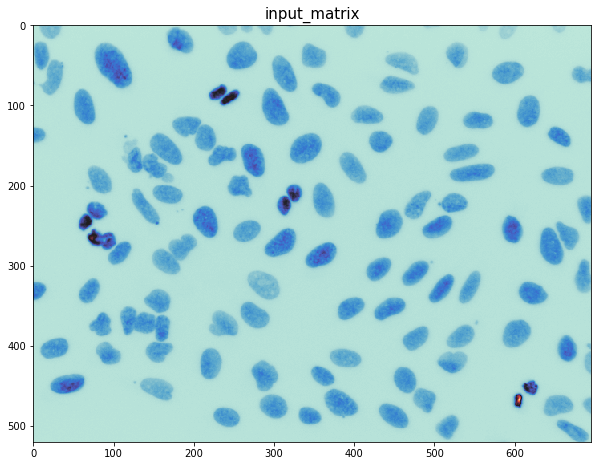

In [151]:
# take a look at the input matrix
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=2)
nmfe.plot(matrix="I", 
          cmap='icefire', 
          size=(10, 10))

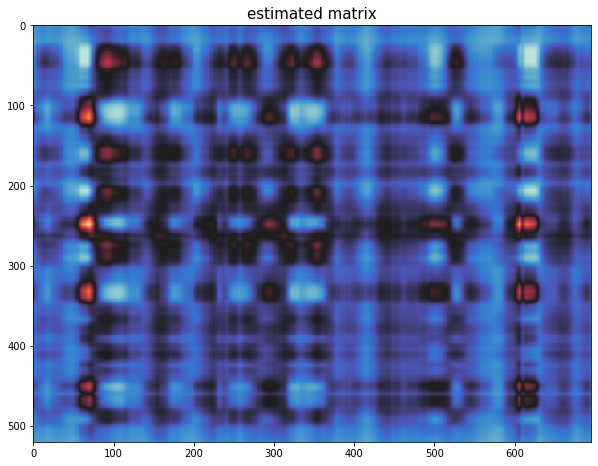

In [152]:
# take a look at the factorization
nmfe.plot(matrix="E", 
          cmap='icefire', 
          size=(10, 10))

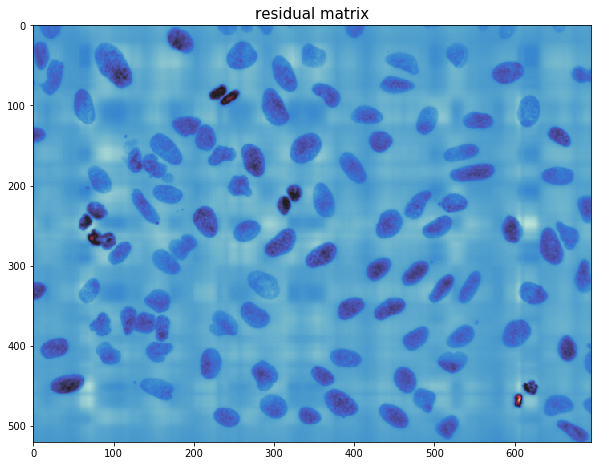

In [153]:
# take a look at the factorization residuals
nmfe.plot(matrix="R", 
          cmap='icefire', 
          size=(10, 10))

Help on method plot_IE in module NMFE:

plot_IE(cmap='Greys', size=(10, 10)) method of NMFE.NMFE instance
    A method to plot `I` and `E` matrices for quick comparisons.
    
    ARGS:
        - cmap (string): a valid color map. 
        
        - size (tuple): the size of the output.
        
    RETURNS:
        - NA. This is just an inline plotting method.



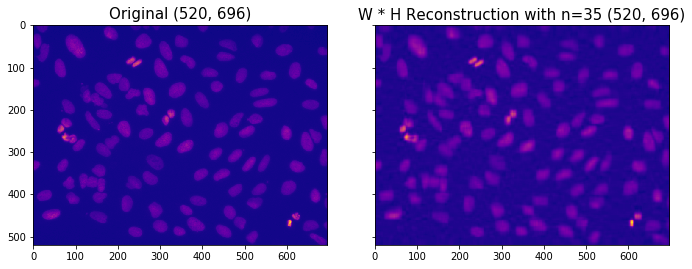

In [154]:
nmfe.refit(n_components = 35)
help(nmfe.plot_IE)
nmfe.plot_IE(cmap='plasma')

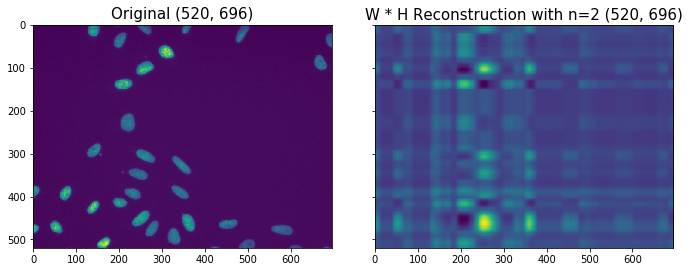

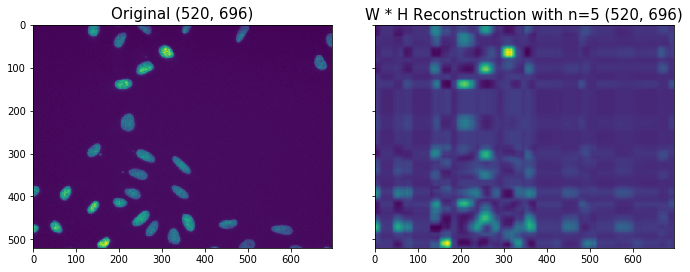

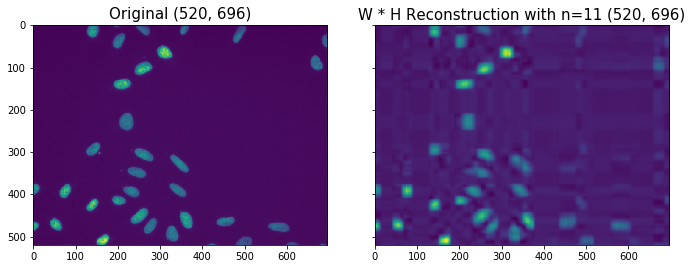

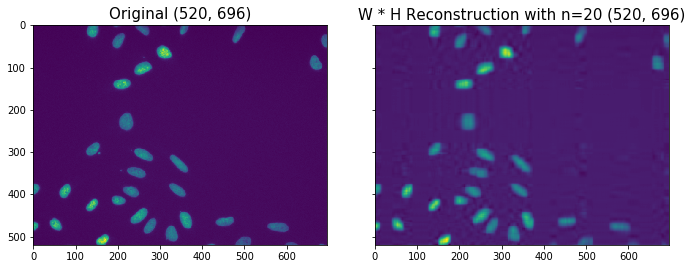

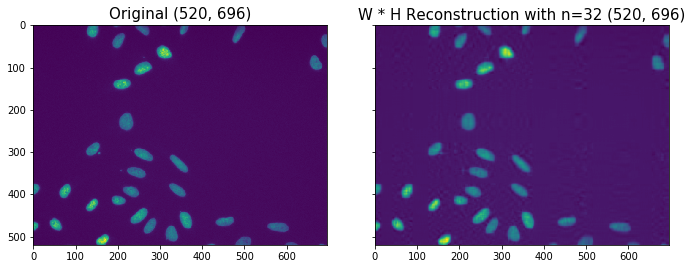

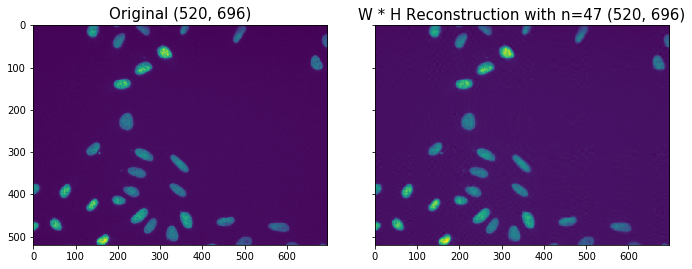

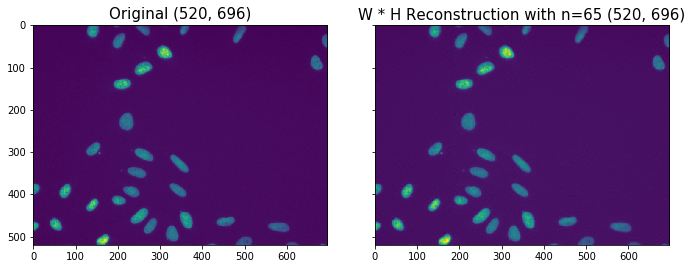

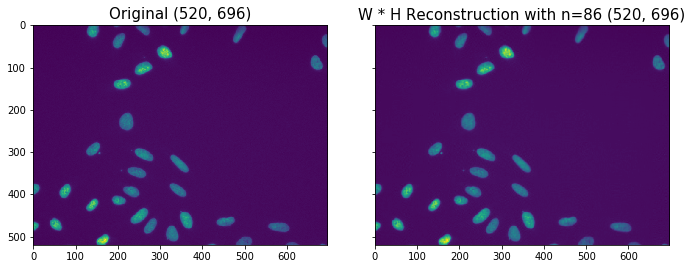

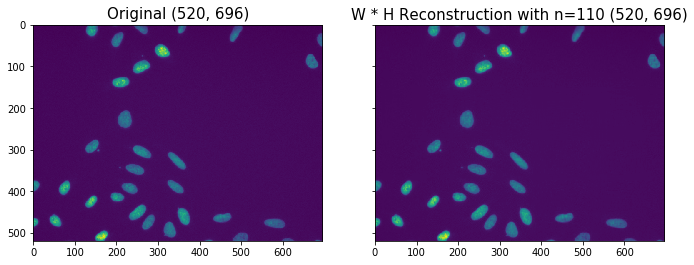

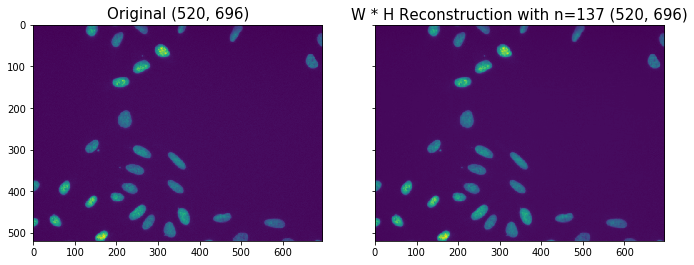

In [161]:
# this is especially helpful for comparing different fits 
# around n~30 the reconstruction is indistinguishable from the input
ix = random.randint(0, len(img_list))

components = 2
nmfe = NMFE(input_matrix=img_list[ix], n_components=components)

for i in range(0, 30, 3):
    components += i
    nmfe.refit(n_components=components)
    nmfe.plot_IE(cmap='viridis')

Help on method plot_all in module NMFE:

plot_all(cmap='Greys', size=(10, 10)) method of NMFE.NMFE instance
    A method to plot matrices I, W, H and E on
    a grid. 
    
    ARGS:
        - cmap (string): a valid color map. 
        
        - size (tuple): the size of the output.
        
    RETURNS:
        - NA. This is just an inline plotting method.



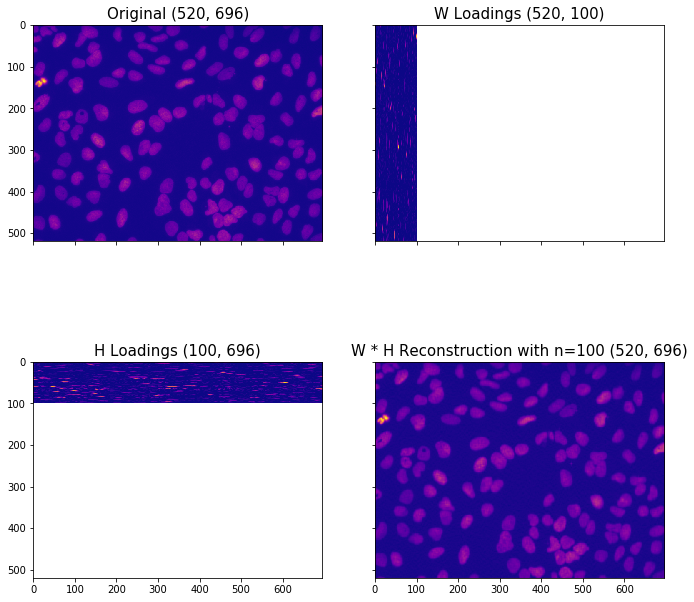

In [158]:
ix = random.randint(0, len(img_list))
nmfe = NMFE(input_matrix=img_list[ix], n_components=100)

help(nmfe.plot_all)
nmfe.plot_all(cmap='plasma')